In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from aux_func import show_history

# RESNET

Referencias https://github.com/suvoooo/Learn-TensorFlow/blob/master/resnet/Implement_Resnet_TensorFlow.ipynb

Definimos la red

In [2]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [3]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [1]:
def resnet50():

  input_im = Input(shape=(X_validation_cifar100.shape[1], X_validation_cifar100.shape[2], X_validation_cifar100.shape[3])) # cifar 100 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage
  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
    
  # 4th stage
  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage
  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))


  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(100, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [8]:
from tensorflow.keras.datasets import cifar100
(X_train_cifar100, y_train_cifar100), (X_validation_cifar100, y_validation_cifar100) = cifar100.load_data()
X_train_cifar100 = X_train_cifar100/255
X_validation_cifar100 = X_validation_cifar100/255

169017344/169001437 [==============================] - 6s 0us/step


In [9]:
#Se realiza One-hot.encoding a las etiquetas
y_train_categorical = tf.keras.utils.to_categorical(
    y_train_cifar100, num_classes=100, dtype='uint8')

y_validation_categorical = tf.keras.utils.to_categorical(
    y_validation_cifar100, num_classes=100, dtype='uint8')

In [10]:
#Data Augmentation 
batch_size =25

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(X_train_cifar100, y_train_categorical, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(X_validation_cifar100, y_validation_categorical, batch_size=batch_size) # so as valid_lab 

In [11]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop    

In [12]:
resnet50_model = resnet50()

In [13]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [14]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['accuracy'])

In [15]:
batch_size=25
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=15, 
                                  steps_per_epoch=200, 
                                  validation_steps=100, 
                                  validation_data=valid_set_conv,
                                  callbacks=[lrdecay])

Epoch 1/15
200/200 [==============================] - 43s 124ms/step - loss: 22.6702 - accuracy: 0.0198 - val_loss: 20.5134 - val_accuracy: 0.0088 - lr: 0.0010
Epoch 2/15
200/200 [==============================] - 24s 119ms/step - loss: 20.2341 - accuracy: 0.0370 - val_loss: 104.2031 - val_accuracy: 0.0196 - lr: 0.0010
Epoch 3/15
200/200 [==============================] - 27s 133ms/step - loss: 17.9264 - accuracy: 0.0352 - val_loss: 80.2010 - val_accuracy: 0.0136 - lr: 0.0010
Epoch 4/15
200/200 [==============================] - 24s 117ms/step - loss: 15.9746 - accuracy: 0.0424 - val_loss: 42.9081 - val_accuracy: 0.0332 - lr: 0.0010
Epoch 5/15
200/200 [==============================] - 24s 118ms/step - loss: 14.2471 - accuracy: 0.0444 - val_loss: 12.5537 - val_accuracy: 0.0336 - lr: 0.0010
Epoch 6/15
200/200 [==============================] - 24s 119ms/step - loss: 13.3816 - accuracy: 0.0360 - val_loss: 15.4842 - val_accuracy: 0.0140 - lr: 0.0010
Epoch 7/15
200/200 [===================

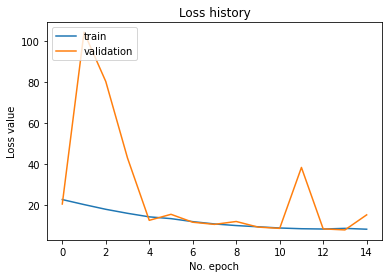

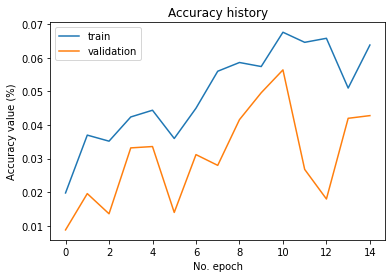

In [16]:
show_history(resnet_train)